In [3]:
%matplotlib notebook
import os
import chaospy as cp
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from statsmodels.distributions.empirical_distribution import ECDF
from matplotlib import cm
from numpy import linalg as LA
import pandas as pd
import seaborn as sns
import itertools
MODEL_NAME      = 'bench1'
WORKING_DIR     = os.getcwd()
MODEL_DIR       = os.path.join(WORKING_DIR, MODEL_NAME)
MODEL_DIR_DATA  = os.path.join(MODEL_DIR,r'Data')
MODEL_DIR_FIGURE= os.path.join(MODEL_DIR,r'Figures')

pltlinestyles = [ (0, (1, 5)),(0, (3, 5, 1, 5)),(0, (5, 5)),(0, ()), (0, (3, 1, 1, 1, 1, 1)), 
        (0, (5, 10)), (0, (3, 10, 1, 10)), (0, (3, 10, 1, 10, 1, 10)),(0, (1, 10)), 
        (0, (5, 1)),  (0, (3, 1, 1, 1)),(0, (3, 5, 1, 5, 1, 5)),  (0, (1, 1))  ]*10

pltmarkers =['o','v','s','d','+','*']
ordinal = lambda n: "%d%s" % (n,"tsnrhtdd"[(math.floor(n/10)%10!=1)*(n%10<4)*n%10::4])
pltcolors = plt.rcParams['axes.prop_cycle'].by_key()['color']


## Test function

## Benchmar Probalem #1
Benchmark problem with 1 dimension normal error:

\begin{equation}
  \begin{aligned}
	y&=f(x)+\epsilon(x), \quad f(x) = x^2 + \sin(5x) \\
	x&\sim N(0,1)\\
    \epsilon &\sim N(0,\sigma(x)), \quad \sigma(x) = 0.5(x^2+1)
  \end{aligned}
  \label{eqn:benchmark1}
\end{equation}



In [7]:
def func(x):
    x = np.array(x)
    return x**2*np.sin(5*x)

def sigma_x(x,sigma=0.5):
    x = np.array(x)
    return sigma*(x**2+1)

def func_normal(x,mu=0,sigma=0.5):
    x = np.array(x)
    sigmas = sigma_x(x,sigma=sigma)
    y0 = func(x)
    e = np.array([np.random.normal(mu, sigma,1) for sigma in sigmas]).reshape((len(x),))
    y = y0 + e
    return y

def func_gumbel(x,mu=0,beta=0.5):
    x = np.array(x)
    x0 = x**2*np.sin(5*x)
    e = np.array([np.random.gumbel(mu, beta*abs(s),1) for s in x]).reshape((len(x),))
    mu, std
    return x0+ e

def feature_map_poly(x,order=5):
    x = np.array(x)
    X = []
    for iorder in np.arange(order):
        X.append(x**iorder)
    return np.array(X).T

(7, 5)


<IPython.core.display.Javascript object>


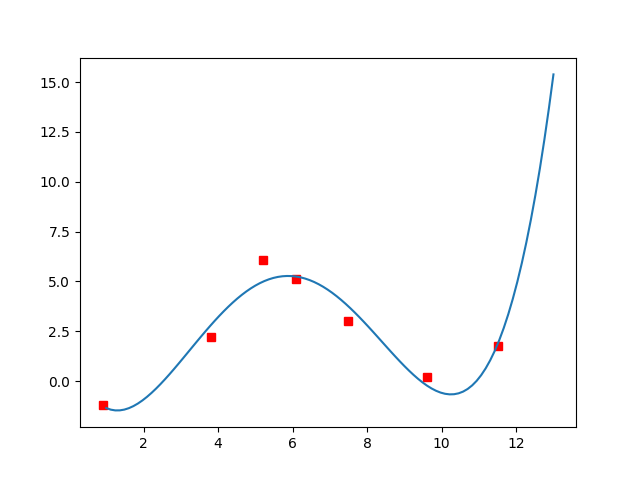

[[ 0.         -4.93011272  2.56129799 -0.36652537  0.01577362]] <bound method RegressorMixin.score of LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)> <bound method BaseEstimator.get_params of LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)>


In [16]:
from sklearn.linear_model import LinearRegression
x = np.array([0.9,3.8,5.2,6.1,7.5,9.6,11.5])
# X = np.array([np.ones(X.shape), X, X**2,X**3,X**4]).T
X = feature_map_poly(x)
print(X.shape)
y = np.array([-1.2,2.2,6.1,5.1,3.0,0.2,1.75]).reshape(-1,1)
reg = LinearRegression().fit(X, y)
plt.figure()
plt.plot(X[:,1],y,'rs')
X_ = feature_map_poly(np.linspace(1,13,100))
plt.plot(X_[:,1], reg.predict(X_))
print(reg.coef_,reg.score,reg.get_params)

<IPython.core.display.Javascript object>


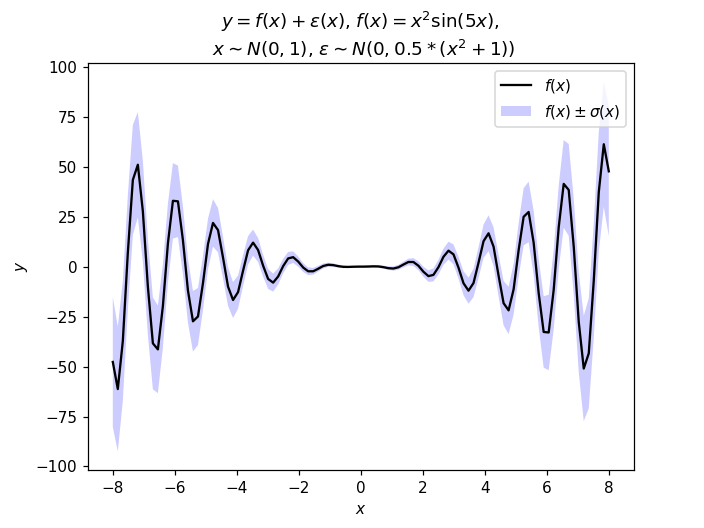

In [69]:
fig = plt.figure()
x = np.linspace(-8,8,100)
y0 = func(x)
sigmas = sigma_x(x)
y = func_normal(x)

ax1 = fig.add_subplot(1,1,1)
ax1.plot(x,y0,'k',label='$f(x)$')
ax1.fill_between(x, y0+sigmas, y0-sigmas, facecolor='blue', alpha=0.2,label='$f(x)\pm \sigma(x)$')
# ax1.plot(x,y0+sigmas,'k-.',label='$f(x)\pm \sigma(x)$')
# ax1.plot(x,y0-sigmas,'k-.')
# plt.plot(x,y,label='$y$')
ax1.set_xlabel('$x$')
ax1.set_ylabel('$y$')
ax1.set_title('$y=f(x)+\epsilon(x)$, $f(x) = x^2  \sin(5x)$,\n $x\sim N(0,1)$, $\epsilon \sim N(0,0.5*(x^2+1))$')
ax1.legend()


## Monte Carlo Simulation

<IPython.core.display.Javascript object>


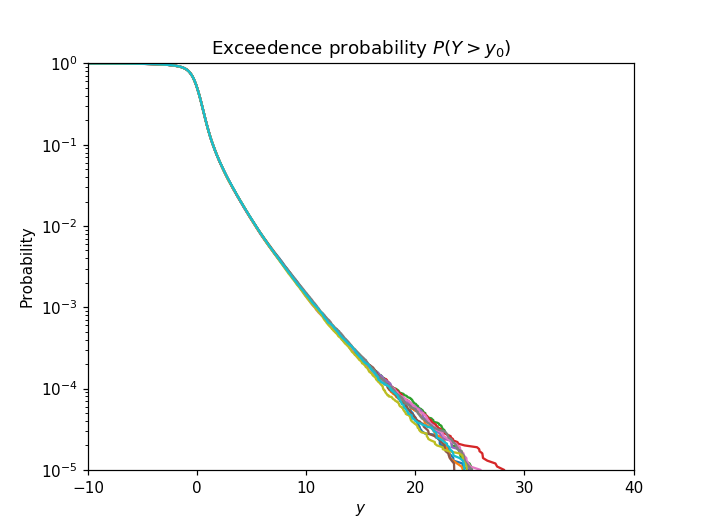

Text(0.5, 1.0, 'Exceedence probability $P(X>x_0)$')

In [33]:
fig = plt.figure()
ax1 = fig.add_subplot(1,1,1)

for i in np.arange(10):
    file_name = 'MC_R_doe'+str(i)+'.npy'
    data_set = np.load(os.path.join(MODEL_DIR_DATA,file_name)) # [var, y, zeta]
    training_x = data_set[0]
    training_y = np.squeeze(data_set[1])
    training_y_ecdf = ECDF(training_y)
    ax1.semilogy(training_y_ecdf.x, 1- training_y_ecdf.y,color=pltcolors[i])

# sns.distplot(training_y);

In [37]:
ax1.set_xlabel(r'$y$')
ax1.set_ylabel(r'Probability')
ax1.set_title(r'Exceedence probability $P(Y>y_0)$')
ax1.set_ylim((1e-5,1))
ax1.set_xlim((-10,40))


(-10, 40)

In [75]:
data_set = np.load(os.path.join(MODEL_DIR_DATA,r'Quadrature_hermite_doe0.npy'))
training_x = data_set[0]
training_y = data_set[1]

print(data_set.shape)
print(training_x.shape)
print(training_y.shape)

(5,)
(1, 10)
(10,)


In [42]:
ax1.plot(training_x,training_y)

In [41]:
a = np.arange(5)
print(a.shape[1])

IndexError: tuple index out of range

In [16]:
print(training_x[1][0].shape)
print(training_y[1][0].shape)
domain = cp.Uniform(0,1)
rule = 'e'
order = 3
coord, weights= cp.generate_quadrature(order-1, domain, rule=rule) 
print(coord)

(1, 300)
(1, 300)
[[0.11270167 0.5        0.88729833]]


In [ ]:
nsamples = 10000
dist_x = cp.Normal(0,1)
xsamples = dist_x.sample(nsamples)
ysamples = func_normal(xsamples)
data = np.array([xsamples, ysamples]).T
print(data.shape)
df = pd.DataFrame(data, columns=["x", "y"])
g=(sns.jointplot(x="x", y="y", data=df, kind='reg').plot_joint(sns.kdeplot, zorder=0, n_levels=6));


## Design of Experiments (DoEs)

In [ ]:
dist_zeta  = cp.Normal(0,1)
## ------------------------------------------------------------------- ###
##  Define DoE parameters  ###
## ------------------------------------------------------------------- ###
doe_params = ['GQ','hermite',5] # doe_method, doe_rule, doe_order
doe_method, doe_rule, doe_order = doe_params[0], doe_params[1], doe_params[2]
#### ------------------------------------------------------------------- ###
#### Define meta model parameters  ###
#### ------------------------------------------------------------------- ###
# quad_metamodel   = metaModel('PCE', [5,6], quad_simparam.doe_method, dist_zeta)

samp_zeta = samplegen(doe_method, doe_order, dist_zeta, rule=doe_rule)
zeta_cor, zeta_weights = samp_zeta
phy_cor = dist_transform(dist_zeta, dist_x, zeta_cor)
phy_weights = zeta_weights
samp_phy = np.array([phy_cor, phy_weights])
print(samp_zeta)
print(samp_phy)

## PCE model

In [ ]:
nrealization = 4
nsamples = len(samp_phy)*20
xsamples = np.linspace(-3,3,nsamples)
ysamples = np.array([func_normal(xsamples) for _ in np.arange(nrealization)]).T
print(ysamples.shape)

In [68]:
mu = np.array([0,1])
sigma = np.array([0,1])
samples = np.random.normal(mu,sigma,100)
print(samples.shape)
print(samples)

ValueError: shape mismatch: objects cannot be broadcast to a single shape

In [66]:
## Gumbel distribution
# nsamples = 1000
# gumbel_mu, gumbel_beta = 0, 1
# xsamples = np.random.gumbel(gumbel_mu, gumbel_beta,nsamples)
# fig = plt.figure()
# count, bins, ignored = plt.hist(xsamples, 40,density=True)
# plt.plot(bins, (1/gumbel_beta)*np.exp(-(bins - gumbel_mu)/gumbel_beta) * np.exp( -np.exp( -(bins - gumbel_mu) /gumbel_beta))
#           ,linewidth=2, color='r')
# plt.show()

In [55]:
n = 10
dist = 'normal'
mu,sigma = 0,1
samples = _stationary_error(n,dist,mu,sigma)
print(samples.shape)

(10,)


In [45]:
a = np.arange(9).reshape(3,3)
print ([b for b in a])

[array([0, 1, 2]), array([3, 4, 5]), array([6, 7, 8])]
